# This analysis is Satellite 1 specific

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
warnings.filterwarnings("ignore")
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from statsmodels.tools.eval_measures import rmse

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def dickeyFuller(series, title):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: ' + '\033[1m' + title + '\033[0m')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data

    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out['critical value ({key})']=val

    print(out.to_string())  # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print(color.BOLD + "Data has no unit root and is stationary" + color.END)
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print(color.BOLD + "Data has a unit root and is non-stationary" + color.END)

def outlierPlot(df, title, col_name):
    area = np.pi * 3
    plt.scatter(df.index,df[col_name] , s=area, alpha=0.5)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    df.boxplot(column=['Transaction'])
    return len(df)

def remove_outlier(df_in, col_name):
    #clear = new_df[(np.abs(stats.zscore(new_df)) < 3)]
    q1 = df_in[col_name].quantile(0.10)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1                                    #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def smape(a, b):

    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

def D3_Plot(x, y, z, title=""):
    fig = plt.figure()
    plt.figure(figsize = (12,8))
    ax = plt.axes(projection='3d')
    ax.plot3D(x, y, z, 'blue')
    ax.set_title(title)
    plt.show()

In [3]:
dataframe = pd.read_csv('train_new.csv')
#original train file was too large. This one only contains satellite 1 data
#results = pd.read_csv('submission.csv')

In [4]:
#len(dataframe[dataframe.sat_id == 1])

In [5]:
dataframe

,Unnamed: 0,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,958,1819,2014-01-01T00:00:00.000,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
1,959,1820,2014-01-01T00:21:11.845,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049
2,960,1821,2014-01-01T00:42:23.690,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255
3,961,1822,2014-01-01T01:03:35.534,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723
4,962,1823,2014-01-01T01:24:47.379,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,3061,3922,2014-01-31T22:15:45.938,1,-33092.618399,-281.511542,-1582.378975,0.094088,-1.839427,1.337545,-29406.078919,-2719.769909,-1476.299104,0.903445,-2.329687,1.355335
2104,3062,3923,2014-01-31T22:36:57.783,1,-32678.193673,-2611.293944,127.879530,0.559090,-1.818598,1.347891,-27882.742274,-5634.903507,259.572177,1.498239,-2.242285,1.367602
2105,3063,3924,2014-01-31T22:58:09.628,1,-31665.342406,-4892.533056,1835.695504,1.036204,-1.762460,1.333303,-25577.429154,-8389.868466,1986.924648,2.134397,-2.074305,1.340251
2106,3064,3925,2014-01-31T23:19:21.473,1,-30034.378237,-7077.220106,3507.336506,1.532305,-1.665557,1.290191,-22432.558095,-10865.836350,3646.968029,2.819524,-1.797623,1.258773


In [6]:
satellite1 = dataframe[dataframe.sat_id == 1]
# satellite1.to_csv("train_new.csv")
satellite1['Datetime'] = pd.to_datetime(satellite1['epoch'], format='%Y-%m-%dT%H:%M:%S.%f')
satellite1.set_index('Datetime', inplace = True)
satellite1.drop('epoch', 1, inplace = True)
satellite1

,Unnamed: 0,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
Datetime,,,,,,,,,,,,,,,
2014-01-01 00:00:00.000,958,1819,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
2014-01-01 00:21:11.845,959,1820,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049
2014-01-01 00:42:23.690,960,1821,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255
2014-01-01 01:03:35.534,961,1822,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723
2014-01-01 01:24:47.379,962,1823,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-31 22:15:45.938,3061,3922,1,-33092.618399,-281.511542,-1582.378975,0.094088,-1.839427,1.337545,-29406.078919,-2719.769909,-1476.299104,0.903445,-2.329687,1.355335
2014-01-31 22:36:57.783,3062,3923,1,-32678.193673,-2611.293944,127.879530,0.559090,-1.818598,1.347891,-27882.742274,-5634.903507,259.572177,1.498239,-2.242285,1.367602
2014-01-31 22:58:09.628,3063,3924,1,-31665.342406,-4892.533056,1835.695504,1.036204,-1.762460,1.333303,-25577.429154,-8389.868466,1986.924648,2.134397,-2.074305,1.340251


<Figure size 432x288 with 0 Axes>

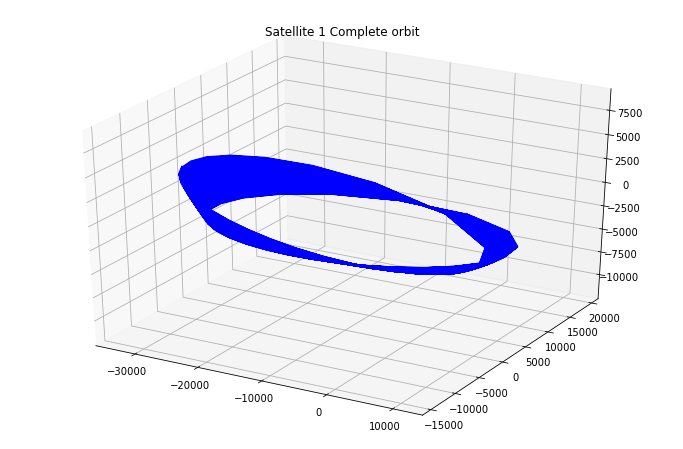

In [7]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z= satellite1['z']
x= satellite1['x']
y= satellite1['y']

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 Complete orbit')
plt.show()

# ARIMA 

In [8]:
output = pd.DataFrame()

In [9]:
dickeyFuller(satellite1['x'], 'For x')
print()
dickeyFuller(satellite1['y'], 'For y')
print()
dickeyFuller(satellite1['z'], 'For z')

Augmented Dickey-Fuller Test: For x
ADF test statistic          -1.234411
p-value                      0.658621
# lags used                 26.000000
# observations            2081.000000
critical value ({key})      -2.567510
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: For y
ADF test statistic          -0.463142
p-value                      0.899011
# lags used                 26.000000
# observations            2081.000000
critical value ({key})      -2.567510
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: For z
ADF test statistic           0.434363
p-value                      0.982736
# lags used                 26.000000
# observations            2081.000000
critical value ({key})      -2.567510
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Dat

In [10]:
df = satellite1.diff()
df.dropna(inplace = True)

In [11]:
dickeyFuller(df['x'], 'For x')
print()
dickeyFuller(df['y'], 'For y')
print()
dickeyFuller(df['z'], 'For z')

Augmented Dickey-Fuller Test: For x
ADF test statistic       -1.658096e+01
p-value                   1.834361e-29
# lags used               2.600000e+01
# observations            2.080000e+03
critical value ({key})   -2.567510e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: For y
ADF test statistic       -1.709921e+01
p-value                   7.497332e-30
# lags used               2.600000e+01
# observations            2.080000e+03
critical value ({key})   -2.567510e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: For z
ADF test statistic       -1.819842e+01
p-value                   2.409314e-30
# lags used               2.600000e+01
# observations            2.080000e+03
critical value ({key})   -2.567510e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no 

In [12]:
auto_arima(df['x'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2107
Model:                     ARMA(5, 0)   Log Likelihood              -17106.148
Method:                       css-mle   S.D. of innovations            811.289
Date:                Tue, 18 Feb 2020   AIC                          34226.296
Time:                        01:12:17   BIC                          34265.868
Sample:                             0   HQIC                         34240.788
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5981    143.099     -0.039      0.969    -286.067     274.870
ar.L1.y        2.0767      0.022     95.420      0.000       2.034       2.119
ar.L2.y       -1.8432      0.050    -36.814      0.000      -1.941      -1.745
ar.L3.y        0.8898      0.061     14.541      0.000       0.770       1.010
ar.L4.y       -0.1893      0.050     -3.781      0.000      -0.287      -0.091
ar.L5.y       -0.0576      0.022     -2.645      0.008      -0.100      -0.015
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0485           -0.3752j            1.1136           -0.0547
AR.2            1.0485           +0.3752j            1.1136            0.0547
AR.3            0.5770           -1.3451j            1.4636           -0.1855
AR.4            0.5770           +1.3451j            1.4636            0.1855
AR.5           -6.5398           -0.0000j            6.5398           -0.5000
-----------------------------------------------------------------------------
"""

In [13]:
auto_arima(df['y'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2107
Model:                     ARMA(4, 0)   Log Likelihood              -16537.815
Method:                       css-mle   S.D. of innovations            619.442
Date:                Tue, 18 Feb 2020   AIC                          33087.630
Time:                        01:12:22   BIC                          33121.548
Sample:                             0   HQIC                         33100.052
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9955    116.382     -0.026      0.979    -231.101     225.110
ar.L1.y        2.1668      0.020    106.976      0.000       2.127       2.207
ar.L2.y       -2.0811      0.045    -46.609      0.000      -2.169      -1.994
ar.L3.y        1.1655      0.045     26.098      0.000       1.078       1.253
ar.L4.y       -0.3672      0.020    -18.109      0.000      -0.407      -0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0547           -0.3842j            1.1225           -0.0556
AR.2            1.0547           +0.3842j            1.1225            0.0556
AR.3            0.5325           -1.3705j            1.4703           -0.1910
AR.4            0.5325           +1.3705j            1.4703            0.1910
-----------------------------------------------------------------------------
"""

In [14]:
auto_arima(df['z'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 2107
Model:                     ARMA(5, 0)   Log Likelihood              -15723.992
Method:                       css-mle   S.D. of innovations            421.013
Date:                Tue, 18 Feb 2020   AIC                          31461.985
Time:                        01:12:25   BIC                          31501.556
Sample:                             0   HQIC                         31476.476
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9128     72.894      0.013      0.990    -141.956     143.781
ar.L1.y        2.0691      0.022     95.120      0.000       2.026       2.112
ar.L2.y       -1.8460      0.050    -37.033      0.000      -1.944      -1.748
ar.L3.y        0.9098      0.061     14.936      0.000       0.790       1.029
ar.L4.y       -0.2103      0.050     -4.219      0.000      -0.308      -0.113
ar.L5.y       -0.0484      0.022     -2.223      0.026      -0.091      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0542           -0.3823j            1.1214           -0.0554
AR.2            1.0542           +0.3823j            1.1214            0.0554
AR.3            0.5676           -1.3576j            1.4715           -0.1870
AR.4            0.5676           +1.3576j            1.4715            0.1870
AR.5           -7.5902           -0.0000j            7.5902           -0.5000
-----------------------------------------------------------------------------
"""

#### Granger test for casuality

In [15]:
grangercausalitytests(satellite1[['x', 'y']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21561.8489, p=0.0000  , df_denom=2104, df_num=1
ssr based chi2 test:   chi2=21592.5930, p=0.0000  , df=1
likelihood ratio test: chi2=5099.3461, p=0.0000  , df=1
parameter F test:         F=21561.8489, p=0.0000  , df_denom=2104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6460.1265, p=0.0000  , df_denom=2101, df_num=2
ssr based chi2 test:   chi2=12951.0008, p=0.0000  , df=2
likelihood ratio test: chi2=4142.6129, p=0.0000  , df=2
parameter F test:         F=6460.1265, p=0.0000  , df_denom=2101, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3068.6347, p=0.0000  , df_denom=2098, df_num=3
ssr based chi2 test:   chi2=9236.6198, p=0.0000  , df=3
likelihood ratio test: chi2=3545.1645, p=0.0000  , df=3
parameter F test:         F=3068.6347, p=0.0000  , df_denom=2098, df_num=3


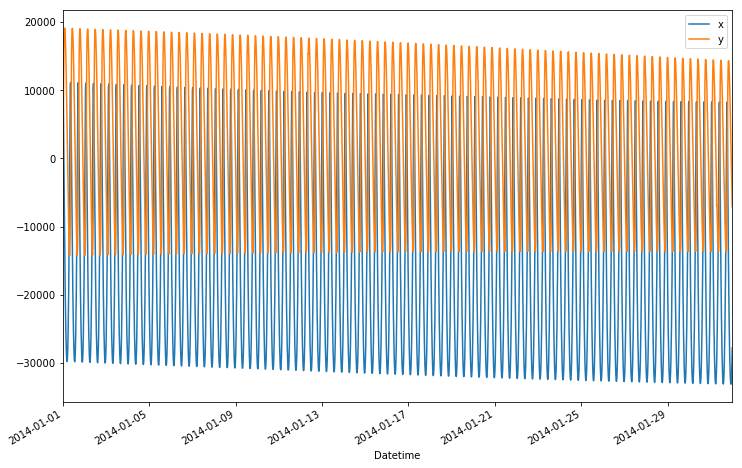

In [16]:
satellite1['x'].iloc[1:].plot(figsize=(12,8), legend = True)
satellite1['y'].shift(1).plot(legend = True)

In [17]:
nobs = 2000
train = df[-nobs:]
test = df[:-nobs]

In [18]:
len(train)

2000

In [19]:
modelx = ARIMA(train['x'], order=(5,1,0))
resultx = modelx.fit()

modely = ARMA(train['y'], order=(4,0))
resulty = modely.fit()

modelz = ARMA(train['z'], order=(5,0))
resultz = modelz.fit()
# result.summary()

In [20]:
start = len(train)
end = len(train) + len(test) -1

In [21]:
predictionsx = resultx.predict(start,end)
predictionsy = resulty.predict(start,end)
predictionsz = resultz.predict(start,end)

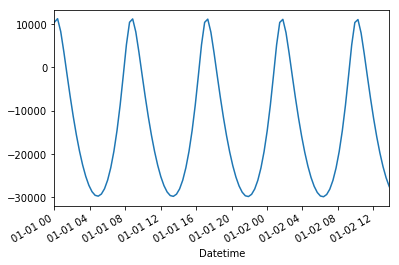

In [22]:
satellite1.x[:-nobs].plot()

In [23]:
predictionsx = satellite1['x'].iloc[-nobs-1] + predictionsx.cumsum()
predictionsy = satellite1['y'].iloc[-nobs-1] + predictionsy.cumsum()
predictionsz = satellite1['z'].iloc[-nobs-1] + predictionsz.cumsum()

In [24]:
output['x'] = predictionsx
output['y'] = predictionsy
output['z'] = predictionsz

<Figure size 432x288 with 0 Axes>

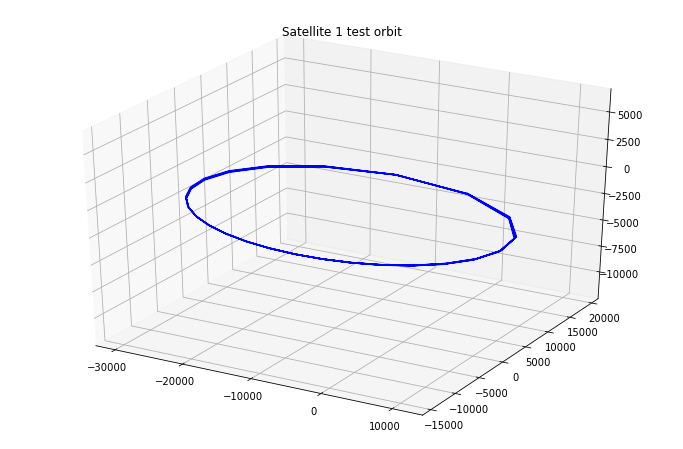

In [25]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = satellite1.z[:-nobs]
x = satellite1.x[:-nobs]
y = satellite1.y[:-nobs]

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 test orbit')
plt.show()

<Figure size 432x288 with 0 Axes>

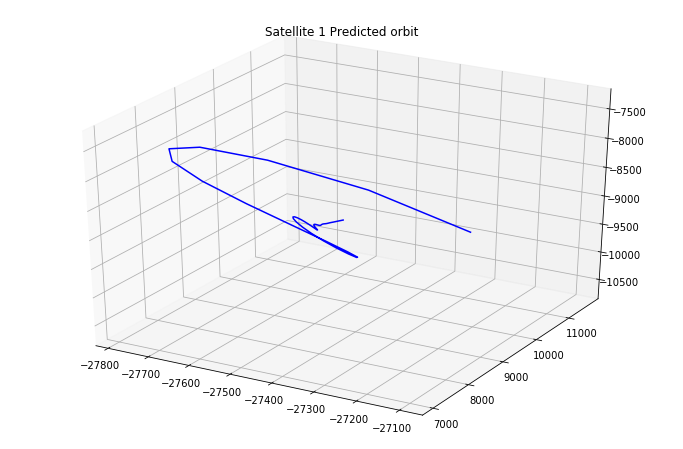

In [26]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = output['z']
x = output['x']
y = output['y']

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 Predicted orbit')
plt.show()

# VARMAX

In [27]:
df

,Unnamed: 0,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
Datetime,,,,,,,,,,,,,,,
2014-01-01 00:21:11.845,1.0,1.0,0.0,805.293744,7875.112239,-4018.638678,-3.647144,-0.323518,-0.428273,794.039581,7873.586015,-4012.856665,-3.639871,-0.330693,-0.423822
2014-01-01 00:42:23.690,1.0,1.0,0.0,-2960.050397,6367.250295,-3841.437430,-2.103560,-1.699980,0.551431,-2960.349332,6362.732095,-3834.361515,-2.096365,-1.698371,0.549794
2014-01-01 01:03:35.534,1.0,1.0,0.0,-4675.406660,4188.290883,-2973.663159,-0.734469,-1.605565,0.726289,-4670.396198,4186.912921,-2970.049329,-0.732859,-1.603024,0.723532
2014-01-01 01:24:47.379,1.0,1.0,0.0,-5140.626668,2389.123189,-2101.110416,-0.086169,-1.224480,0.631640,-5135.361458,2390.093069,-2100.641414,-0.086790,-1.223282,0.629713
2014-01-01 01:45:59.224,1.0,1.0,0.0,-5047.031164,1040.661419,-1374.597846,0.195191,-0.912595,0.513309,-5043.075969,1042.396129,-1376.052052,0.194078,-0.912410,0.512178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-31 22:15:45.938,1.0,1.0,0.0,-172.590552,-2335.244278,1682.100904,0.459083,-0.012052,0.033848,788.901480,-2984.367485,1699.739465,0.561300,0.023522,0.043608
2014-01-31 22:36:57.783,1.0,1.0,0.0,414.424726,-2329.782402,1710.258505,0.465002,0.020829,0.010346,1523.336645,-2915.133598,1735.871281,0.594794,0.087402,0.012267
2014-01-31 22:58:09.628,1.0,1.0,0.0,1012.851267,-2281.239112,1707.815974,0.477114,0.056139,-0.014588,2305.313120,-2754.964959,1727.352471,0.636159,0.167980,-0.027352


In [28]:
satellite_orbit = pd.DataFrame()
satellite_orbit['x'] = df['x']
satellite_orbit['y'] = df['y']
satellite_orbit['z'] = df['z']

In [29]:
satellite_orbit

,x,y,z
Datetime,,,
2014-01-01 00:21:11.845,805.293744,7875.112239,-4018.638678
2014-01-01 00:42:23.690,-2960.050397,6367.250295,-3841.437430
2014-01-01 01:03:35.534,-4675.406660,4188.290883,-2973.663159
2014-01-01 01:24:47.379,-5140.626668,2389.123189,-2101.110416
2014-01-01 01:45:59.224,-5047.031164,1040.661419,-1374.597846
...,...,...,...
2014-01-31 22:15:45.938,-172.590552,-2335.244278,1682.100904
2014-01-31 22:36:57.783,414.424726,-2329.782402,1710.258505
2014-01-31 22:58:09.628,1012.851267,-2281.239112,1707.815974


In [30]:
test, train = satellite_orbit[:-nobs], satellite_orbit[-nobs:]

In [31]:
train

,x,y,z
Datetime,,,
2014-01-02 14:09:19.239,-1425.900462,-2713.549552,1226.603149
2014-01-02 14:30:31.084,-806.839927,-2873.357946,1410.650812
2014-01-02 14:51:42.929,-160.726623,-2972.951316,1566.737892
2014-01-02 15:12:54.773,519.754322,-3009.360700,1694.421890
2014-01-02 15:34:06.618,1243.745300,-2974.308259,1790.704303
...,...,...,...
2014-01-31 22:15:45.938,-172.590552,-2335.244278,1682.100904
2014-01-31 22:36:57.783,414.424726,-2329.782402,1710.258505
2014-01-31 22:58:09.628,1012.851267,-2281.239112,1707.815974


In [32]:
model = VAR(train)

In [33]:
for p in range(65,75):
    result = model.fit(p)
    print(color.BOLD + f'Order: {p}' + color.END)
    print(f'AIC: {result.aic}')
    print()

Order: 65
AIC: 10.13292569831711

Order: 66
AIC: 9.785634076225406

Order: 67
AIC: 9.730174261127384

Order: 68
AIC: 9.70987116023712

Order: 69
AIC: 9.57374011392329

Order: 70
AIC: 9.387217196555017

Order: 71
AIC: 9.389031583025163

Order: 72
AIC: 9.378894971155983

Order: 73
AIC: 9.37594855059301

Order: 74
AIC: 9.349223099846405



In [34]:
result = model.fit(70)

In [35]:
lag_val = train.values[-70:]

In [36]:
z = result.forecast(y=lag_val, steps=len(test))

In [37]:
# idx = pd.date_range('2014-02-01', period=12, freq='D')

In [38]:
df_forecast = pd.DataFrame(data=z, columns=['X', 'Y', 'Z'])
df_forecast

,X,Y,Z
0,-3.621411e+04,2.725510e+04,-2.194450e+04
1,5.166734e+04,-6.842498e+04,5.139054e+04
2,5.651343e+04,-4.013119e+03,6.897323e+03
3,-6.624472e+04,1.194434e+05,-8.705707e+04
4,-3.961730e+04,1.587564e+04,-1.150714e+04
...,...,...,...
102,-5.714552e+07,1.267770e+08,-9.321010e+07
103,-8.247463e+07,-7.543822e+06,-8.987398e+05
104,2.811134e+08,-3.055711e+08,2.345510e+08
105,-1.715817e+08,3.671134e+08,-2.686478e+08


In [39]:
forecast = pd.DataFrame()
forecast['X'] = satellite1['x'].iloc[-nobs-1] + df_forecast['X'].cumsum()
forecast['Y'] = satellite1['y'].iloc[-nobs-1] + df_forecast['Y'].cumsum()
forecast['Z'] = satellite1['z'].iloc[-nobs-1] + df_forecast['Z'].cumsum()

<Figure size 432x288 with 0 Axes>

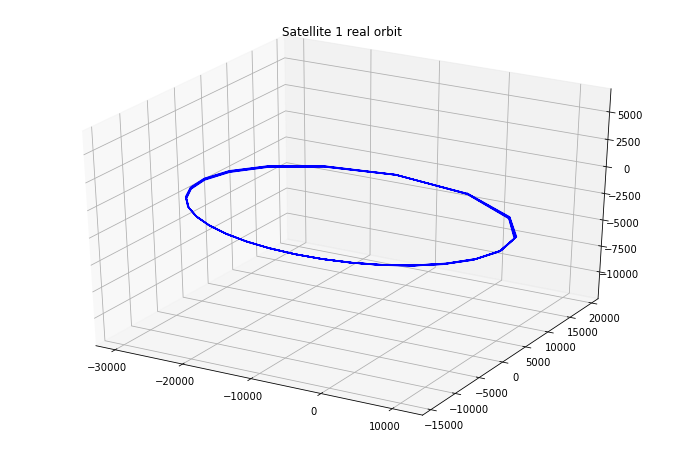

In [40]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = satellite1.z[:-nobs]
x = satellite1.x[:-nobs]
y = satellite1.y[:-nobs]

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 real orbit')
plt.show()

<Figure size 432x288 with 0 Axes>

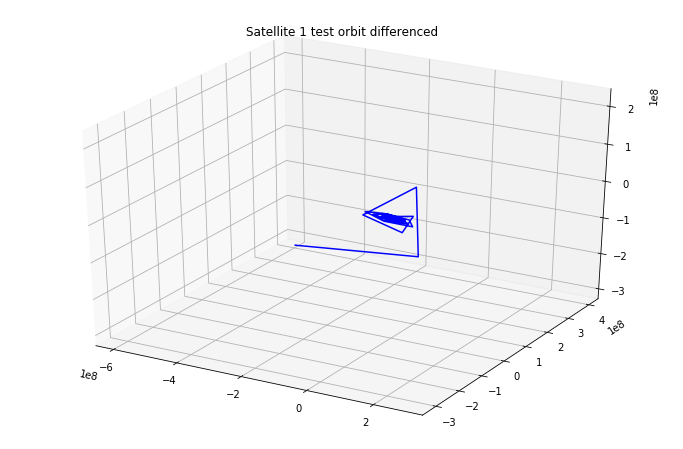

In [41]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = df_forecast.Z
x = df_forecast.X
y = df_forecast.Y

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 test orbit differenced')
plt.show()

<Figure size 432x288 with 0 Axes>

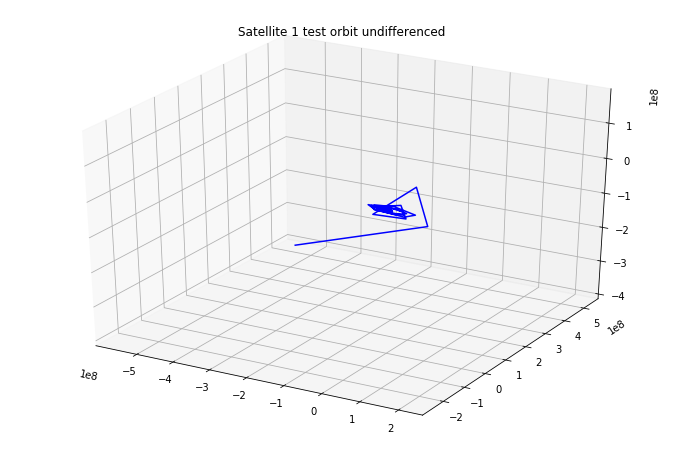

In [42]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = forecast.Z
x = forecast.X
y = forecast.Y

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 test orbit undifferenced')
plt.show()

In [43]:
rmse(test, forecast)

array([60078685.69188237, 59010968.73839363, 45048766.04258143])

In [44]:
auto_arima(satellite_orbit['x'], maxiter=10)

ARIMA(callback=None, disp=0, maxiter=10, method=None, order=(4, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [45]:
auto_arima(satellite_orbit['y'], maxiter=10)

ARIMA(callback=None, disp=0, maxiter=10, method=None, order=(4, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [46]:
auto_arima(satellite_orbit['z'], maxiter=10)

ARIMA(callback=None, disp=0, maxiter=10, method=None, order=(4, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [47]:
test, train = satellite_orbit[0:-nobs], satellite_orbit[-nobs:]

In [48]:
train

,x,y,z
Datetime,,,
2014-01-02 14:09:19.239,-1425.900462,-2713.549552,1226.603149
2014-01-02 14:30:31.084,-806.839927,-2873.357946,1410.650812
2014-01-02 14:51:42.929,-160.726623,-2972.951316,1566.737892
2014-01-02 15:12:54.773,519.754322,-3009.360700,1694.421890
2014-01-02 15:34:06.618,1243.745300,-2974.308259,1790.704303
...,...,...,...
2014-01-31 22:15:45.938,-172.590552,-2335.244278,1682.100904
2014-01-31 22:36:57.783,414.424726,-2329.782402,1710.258505
2014-01-31 22:58:09.628,1012.851267,-2281.239112,1707.815974


In [49]:
model = VARMAX(train, order=(4,3), trend='c')

In [50]:
results = model.fit(maxiter=10, disp=False)

In [51]:
results.summary()

Dep. Variable:,"['x', 'y', 'z']",No. Observations:,2000
Model:,"VARMA(4,3)",Log Likelihood,-37805.460
,+ intercept,AIC,75754.920
Date:,"Tue, 18 Feb 2020",BIC,76158.185
Time:,01:16:26,HQIC,75902.991
Sample:,0,,
,- 2000,,
Covariance Type:,opg,,
Ljung-Box (Q):,"602.10, 1467.87, 1863.34",Jarque-Bera (JB):,"4934793.25, 140893.22, 3238.44"
Prob(Q):,"0.00, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.60, 1.32, 0.86",Skew:,"-3.90, 1.76, -0.38"


In [52]:
df_forecast = pd.DataFrame()
df_forecast = results.forecast(len(test))

<Figure size 432x288 with 0 Axes>

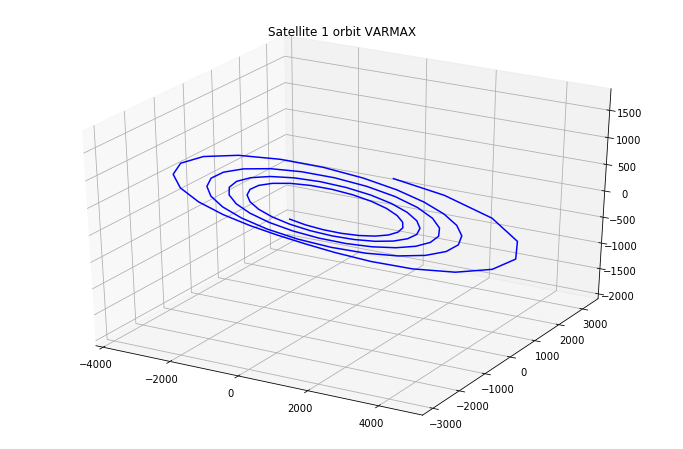

In [53]:
fig = plt.figure()
plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

z = df_forecast.z
x = df_forecast.x
y = df_forecast.y

ax.plot3D(x, y, z, 'blue')
ax.set_title('Satellite 1 orbit VARMAX')
plt.show()

In [54]:
rmse(test, df_forecast)

array([4516.85033884, 3766.2408169 , 2076.39440247])